In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..\\..'))
	print(os.getcwd())
except:
	pass


In [2]:
% matplotlib inline
import datetime
import os

import numpy as np
import pandas as pd
import sklearn.ensemble as skem
import sklearn.feature_selection as skselect
import sklearn.linear_model as skmod
import sklearn.metrics as skmet
import sklearn.svm as sksvm
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split

import recipes.evaluation_classification as evalc
# import recipes.evaluation_classification as evalc
import recipes.exploratory_analysis as eda
import recipes.feature_reduction as freduct
import recipes.feature_selection as fselect
import recipes.hypothesis as hyp
import recipes.plot as rg
import recipes.projection_evaluation as prj
from recipes.exploratory_analysis import (descriptive_statistics,
                                          print_column_datatypes)

print("All libraries loaded!!")


C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


All libraries loaded!!


In [3]:
def preprocess_data(df):
    # data cleaning and completion
    # replace white spaces
    df.columns = [x.strip().replace("+", "").replace(" ", "_") for x in df.columns]

    # filter columns related to weather events
    weather_columns = df.columns.tolist()
    weather_columns = [x for x in weather_columns if "DEC_EVENT" in x]
    selected_cols = ["IDEST", "ZV", "DATE", "DETECTADO"] + weather_columns
    df = df[selected_cols]
    df.columns = [x.lower() for x in df.columns]
    selected_cols = [x.lower() for x in selected_cols]


    # df.drop(["Temperatura"], axis=1, inplace=True)
    # df.drop([y_var], axis=1, inplace = True)
    # ordenar columnas por nombre
    df = df.reindex_axis(sorted(df.columns), axis=1)
    return df



In [4]:
input_file = "resources/processed/full_data.h5"
output_folder = "report/"


# Lectura de datos
Tenemos los datos de las estaciones climatológicas de 2015 en adelante asociados a los datos de
campo en el fichero hd5 full_data.h5.


In [5]:
# read and clean data
df = pd.read_hdf(input_file)


In [6]:
df = preprocess_data(df)
print("data loaded!")


data loaded!


C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


# EDA (Exploratory Data Analysis)
Imprimir boxplot de datos para ver posibles outlayers

# Analizar correlación de datos
Imprimimos las matrices de correlación entre las variables del dataset.



>>>> Data correlations method spearman


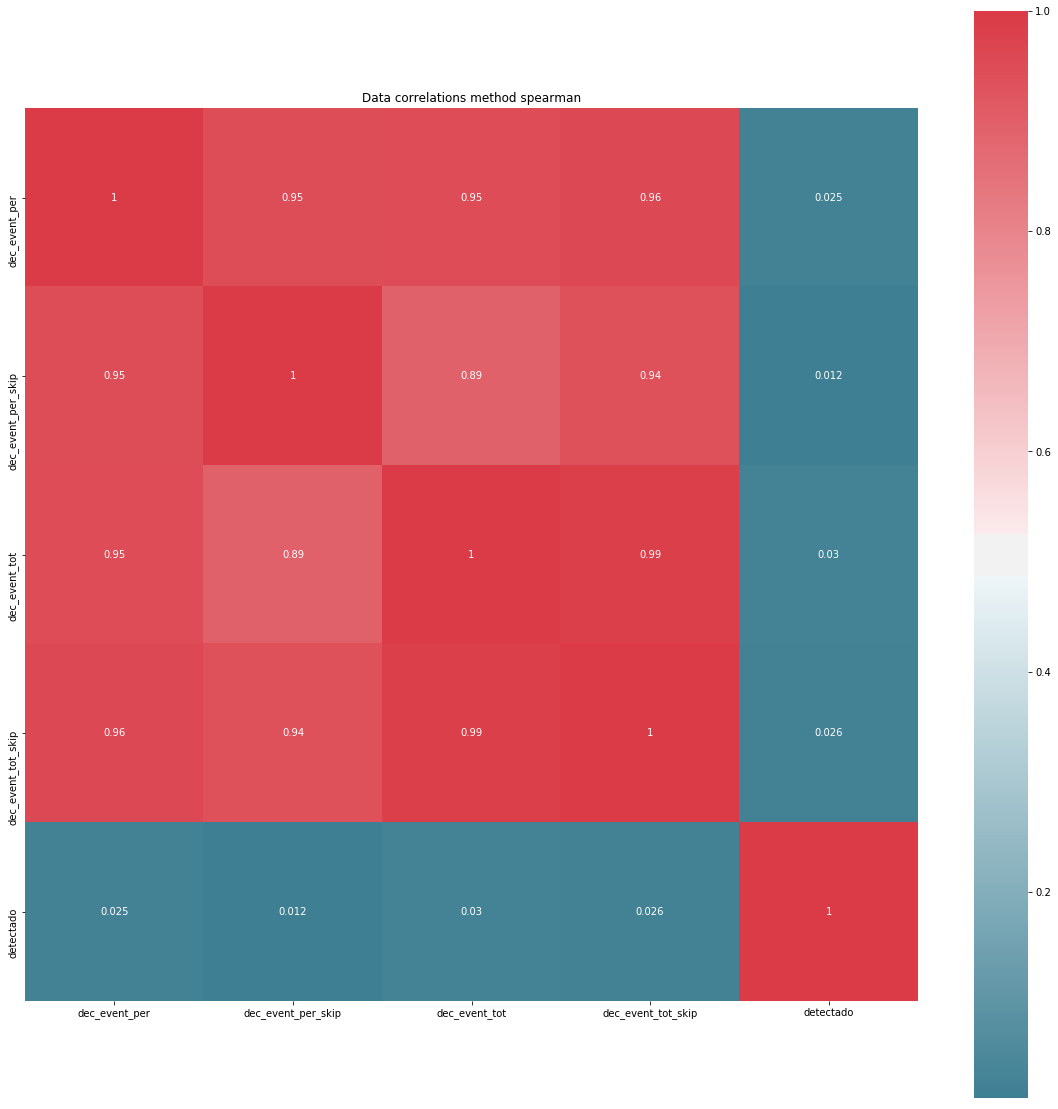

In [7]:
corr_matrix = eda.analyze_correlation(df, corr_method="spearman",
                                      output_file=os.path.join(output_folder, "corr_spearman.png"))



En el caso de variables dependientes categóricas con variables explicativas contínuas tenemos dos opciones
 para valorar la correlación:
* Si la variable categóricos es dicotómica podríamos utilizar el método de Point Biserial, pero impone 
restricciones fuertes en las variables explicativas contínuas, como que éstas sean normales, tendríamos que 
recurrir a algún tipo de transformación.
* La opción que nos queda es aplicar diferentes modelos de regresión logística incluyendo/eliminando 
diferentes variables y valorar la correlación en función de la capacidad predictiva del clasificador.

![Esquemas correlacion](images/correlation_options.png)


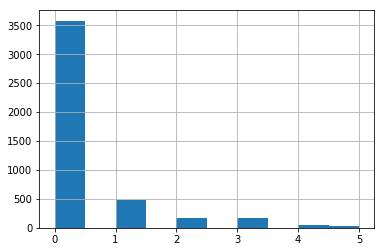

In [8]:
# response variable classes balance
df["detectado"].hist()


Primera aproximación, entrenamos varios modelos y aplicamos validación
 cruzada sobre la métrica F1 para determinar si las variables X son buenas
  predictoras de la variable categórica "detectado".

Preprocesado de datos:
1. Filtramos columnas para quedarnos únicamene con eventos de la décaca
2. Normalizar y Standarizar dataset
3. Como las clases están desbalanceadas convertimos los datos para subrepresentar la clase mayoritaria (no-detectado) y aparte, agrupamos las categorías para tener únicamente dos clases (0,1)


In [9]:
# treat DETECTADO as dicotomic variable
df.loc[df["detectado"] > 0, ["detectado"]] = 1

y_var = "detectado"
y = df[y_var]
exclude_cols = [y_var, "date", "zv", "idest"]
exclude_cols.extend([x for x in df.columns if (
    "temp_" in x) or ("hum_" in x) or ("prec_" in x)])
X = df.drop(exclude_cols, axis=1)
# normalizar y estandarizar
X = eda.normalize_data_sklearn(X)
X = eda.standardize_data_sklearn(X)
X_full = X.copy()
y_full = y.copy()
# undersampling de clase mayoritaria
cc = RandomUnderSampler(ratio="majority")
X_sampled, y_sampled = cc.fit_sample(X, y)
X = pd.DataFrame(X_sampled, columns=X.columns)
y = pd.Series(y_sampled)


Histograma de categorías resultantes

(array([906.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        906.]),
 array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
        0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
        0.83333333, 0.91666667, 1.        ]),
 <a list of 12 Patch objects>)

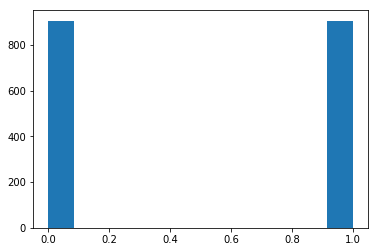

In [10]:
plt.hist(y, bins="auto")


Entrenamos modelos más representativos utilizando validación cruzada y manteniendo la proporción de las clases en cada split de datos.
Cada modelo se entrena 10 veces y de cada entrenamiento obtenemos la medida de la métrica F1 para después
representar la distribución de la tasa de acierdo del clasificador con un boxplot.

C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Desarrollo\tools\anaconda3\envs\

['f1']: XTree 0.2638 (0.2436)
['f1']: LogRg 0.0951 (0.1741)
['f1']: Ridge 0.0917 (0.1666)
['f1']: SVM-L 0.0905 (0.1639)


C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


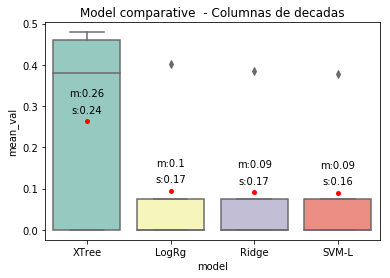

In [11]:
kfold = StratifiedKFold(n_splits=10)

models = [["LogRg", skmod.LogisticRegression()],
          # ["Lasso", skmod.Lasso()],
          ["Ridge", skmod.RidgeClassifier()],
          # ["PasAgr", skmod.PassiveAggressiveClassifier()],
          # ["kMeans", KNeighborsClassifier()],
          ["XTree", skem.ExtraTreesClassifier()],
          ["SVM-L", sksvm.LinearSVC()],
          # ["GausNB", GaussianNB()],
          # ["SVC-l", sksvm.SVC(kernel='linear')],
          # ["SVC-RBF", sksvm.SVC(kernel='rbf')]
          ]
# métrica F1-score para balancear error tipo I - Tipo 2
scoring = "f1"
summary = evalc.cross_val_summary_simple(
    models, X, y, scoring=scoring, options={"title": "Columnas de decadas"})

Entrenamos el modelo que mejor se comporta con el 
conjunto de datos completo separando de test/entrenamiento de forma aleatoria a un 30/70 y 
mostramos la matriz de confusión del clasificador resultante para valorar los errores tipo I y II.
Este sería el caso más optimista, los valores van a ser mayores que en el caso de la validación cruzada al utilizar todo el conjunto de datos.

Normalized confusion matrix


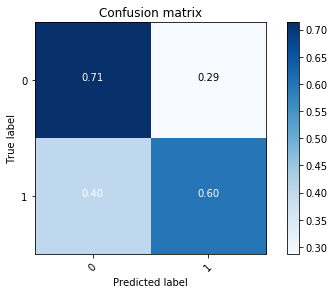

In [12]:
model = skem.ExtraTreesClassifier()
# metrics=["accuracy", "roc_auc"])
summary = evalc.cross_val_summary(models, X, y, metrics=["f1"])

X_train, X_test, Y_train, y_true = train_test_split(
    X, y, test_size=0.3, stratify=y)
model.fit(X_train, Y_train)
y_predicted = model.predict(X_test)

cmtx = skmet.confusion_matrix(y_true, y_predicted)
class_names = np.unique(y)
evalc.plot_confusion_matrix(
    cmtx, classes=class_names, normalize=True)


In [13]:
report = skmet.classification_report(y_true, y_predicted)
# cálculo de f1 score en función de recall/precision
print(report)



             precision    recall  f1-score   support

          0       0.64      0.71      0.67       272
          1       0.68      0.60      0.64       272

avg / total       0.66      0.66      0.66       544



Cargamos los datos completos y entrenamos un clasificador completo para compararlo con el caso balanceado, en este caso el clasificador tiene mejor valor de F1 general a costa de perder precisión y exhaustividad en la clase minoritaria (detectado = 1).

C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_f

Normalized confusion matrix


C:\Desarrollo\tools\anaconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


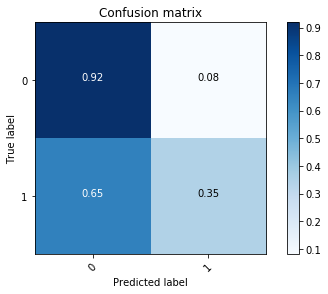

In [14]:
model = skem.ExtraTreesClassifier()
# metrics=["accuracy", "roc_auc"])
X = X_full
y = y_full
summary = evalc.cross_val_summary(models, X, y, metrics=["f1"])

X_train, X_test, Y_train, y_true = train_test_split(
    X, y, test_size=0.3, stratify=y)
model.fit(X_train, Y_train)
y_predicted = model.predict(X_test)

cmtx = skmet.confusion_matrix(y_true, y_predicted)
class_names = np.unique(y)
evalc.plot_confusion_matrix(
    cmtx, classes=class_names, normalize=True)



In [15]:
report = skmet.classification_report(y_true, y_predicted)
# cálculo de f1 score en función de recall/precision
print(report)


             precision    recall  f1-score   support

          0       0.85      0.92      0.88      1074
          1       0.52      0.35      0.42       272

avg / total       0.78      0.80      0.79      1346

